# RTF Model for predicting zone with Peaks - Vibrations

Import

In [59]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

ReadCsv function

In [98]:
def readCsvFolder(folder_path, with_data=True):
    files = []
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            full_path = os.path.join(folder_path, filename)
            files.append(full_path)
            if with_data:
                try:
                    df = pd.read_csv(full_path, header=None)
                    data.append(df)
                except Exception as e:
                    print(f"Erreur en lisant {full_path} : {e}")
    return (data, files) if with_data else files

# Lecture des fichiers
csv_data_list, filenames = readCsvFolder("/Users/vincentdamery/Desktop/projet_vibration/ModelMLAgeRacket/Data_Clean/Chanel0_Data_Columns/P1_clean/RB")



Spectrum

In [99]:

def spectrumFromCsv(csv_data, sample_rate):
    signal = csv_data.iloc[:, 0].values
    spectrum = fft(signal)
    magnitude = abs(spectrum[:len(spectrum) // 2])
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)[:len(magnitude)]
    return freqs, magnitude


Extract each peak and store

In [100]:
def energy_per_frequency_band_from_spectrum(spectrum, freqs, band_width):
    # Calculate energy per band
    band_energies = []
    band_frequencies = []
    for start_freq in range(0, int(freqs[-1]), band_width):
        end_freq = start_freq + band_width
        band_indices = np.where((freqs >= start_freq) & (freqs < end_freq))[0]
        band_energy = np.sum(spectrum[band_indices]**2)  # Sum of squared magnitudes
        band_energies.append(band_energy)
        band_frequencies.append((start_freq + end_freq) / 2)  # Center frequency of the band

    return band_energies, band_frequencies


## Main

In [101]:
sample_rate = 20000
band_width = 50

raquetteTypeList = {"RB": 0, "RO": 1, "RR": 2, "RV": 3}
zones = ["C", "S", "V"]

X = []
y = []

for raquette in raquetteTypeList:
    folder_path = f"/Users/vincentdamery/Desktop/projet_vibration/ModelMLAgeRacket/Data_Clean/Chanel0_Data_Columns/P1_clean/{raquette}"
    csv_data_list, filenames = readCsvFolder(folder_path)

    for i, csv_data in enumerate(csv_data_list):
        freqs, spectrum = spectrumFromCsv(csv_data, sample_rate)

        # Filtrage de la bande [150 Hz, 1000 Hz]
        band_mask = (freqs >= 150) & (freqs <= 1000)
        filtered_freqs = freqs[band_mask]
        filtered_spectrum = spectrum[band_mask]

        # Extraire les énergies par bande
        energy_features = energy_per_frequency_band_from_spectrum(filtered_spectrum, filtered_freqs, band_width)
        X.append(energy_features)

        # Récupération du label de zone dans le nom du fichier
        file_name = os.path.basename(filenames[i])
        if 'C' in file_name:
            zone = 'C'
        elif 'S' in file_name:
            zone = 'S'
        elif 'V' in file_name:
            zone = 'V'
        else:
            zone = 'unknown'
        y.append(zone)




In [102]:


# Encodage des labels (C, V, S → 0, 1, 2)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [103]:
results = []

sample_rate = 20000
band_width = 50

raquetteTypeList = {"RB": 0, "RO": 1, "RR": 2, "RV": 3}
zones = ["C", "S", "V"]


for band_width in range(10, 101, 5):
    
    X = []
    y = []

    
    for raquette in raquetteTypeList:
        folder_path = f"/Users/vincentdamery/Desktop/projet_vibration/ModelMLAgeRacket/Data_Clean/Chanel0_Data_Columns/P1_clean/{raquette}"
        csv_data_list, filenames = readCsvFolder(folder_path)

        for i, csv_data in enumerate(csv_data_list):
            freqs, spectrum = spectrumFromCsv(csv_data, sample_rate)

            # Filtrage de la bande [150 Hz, 1000 Hz]
            band_mask = (freqs >= 150) & (freqs <= 1000)
            filtered_freqs = freqs[band_mask]
            filtered_spectrum = spectrum[band_mask]

            # Extraire les énergies par bande
            energy_features = energy_per_frequency_band_from_spectrum(filtered_spectrum, filtered_freqs, band_width)
            X.append(energy_features)

            # Récupération du label de zone dans le nom du fichier
            file_name = os.path.basename(filenames[i])
            if 'C' in file_name:
                zone = 'C'
            elif 'S' in file_name:
                zone = 'S'
            elif 'V' in file_name:
                zone = 'V'
            else:
                zone = 'unknown'
            y.append(zone)
            
    
        # Encodage des labels (C, V, S → 0, 1, 2)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    n_estimators_range = range(10, 101, 10)  # Nombre d'arbres entre 10 et 100
    max_depth_range = [None, 10, 20, 30, 40]  # Profondeurs différentes
    min_samples_split_range = [2, 5, 10]  # Nombre minimum pour diviser un nœud
    min_samples_leaf_range = [1, 2, 4]  # Nombre minimum d'échantillons dans une feuille
    max_features_range = ['sqrt', 'log2', None]  # Nombre de features par arbre

            # Tester toutes les combinaisons d'hyperparamètres
    for n_estimators in n_estimators_range:
                print(n_estimators)
                for max_depth in max_depth_range:
                    for min_samples_split in min_samples_split_range:
                        # Créer et entraîner le modèle Random Forest
                        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                                    min_samples_split=min_samples_split, random_state=42)
                        rf.fit(X_train, y_train)

                        # Évaluer sur l'ensemble de test
                        y_pred = rf.predict(X_test)
                        accuracy_test = accuracy_score(y_test, y_pred)

                        # Évaluer sur l'ensemble d'entraînement
                        y_train_pred = rf.predict(X_train)
                        accuracy_train = accuracy_score(y_train, y_train_pred)


                        # Ajouter le nom du canal aux résultats
                        results.append({
                            'band_width': band_width,
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'accuracy_test': accuracy_test,
                            'accuracy_train': accuracy_train,
                        })
                        
                    
# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)


# Enregistrer les résultats dans un fichier Excel
results_df.to_excel("V_RTF_ZONE_P1_Energie.xlsx", index=False)

print("Results have been saved to 'V_RTF_ZONE_P1_Energie.xlsx'.")

sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

# Afficher les résultats triés
print(sorted_results_df)



10


ValueError: Found array with dim 3. RandomForestClassifier expected <= 2.

In [ ]:
for band_width in range(10, 101, 5):

Extract peaks

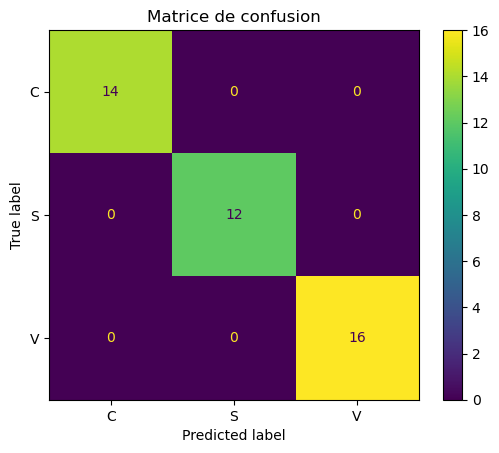

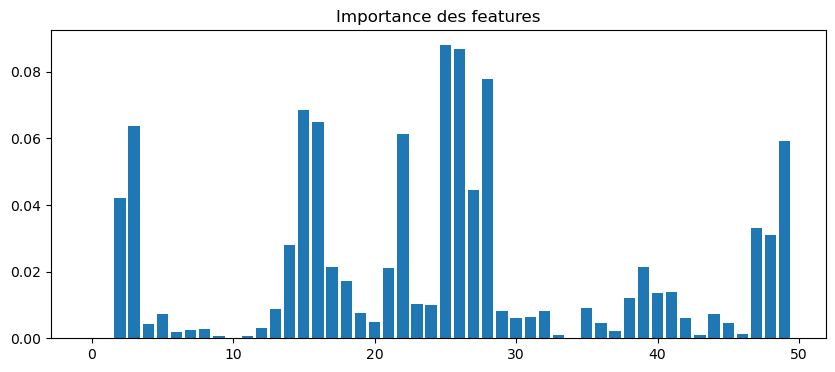

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()

importances = rf.feature_importances_
plt.figure(figsize=(10, 4))
plt.bar(range(len(importances)), importances)
plt.title("Importance des features")
plt.show()
